<a href="https://colab.research.google.com/github/DJCordhose/ml-workshop/blob/master/notebooks/tf2/tf-surrogate-model-dropout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Decision Trees as Surrogate Model for NNs

* https://arxiv.org/abs/1904.05394
* https://colab.research.google.com/github/djcordhose/ml-workshop/blob/master/notebooks/classic/dt-intro.ipynb

In [1]:
# Gives us a well defined version of tensorflow

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

# will also work, but nightly build might contain surprises

# !pip install -q tf-nightly-gpu-2.0-preview

TensorFlow 2.x selected.


In [2]:
import tensorflow as tf
print(tf.__version__)

2.0.0


In [0]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [0]:
# ignore this, it is just technical code to plot decision boundaries
# Adapted from:
# http://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html
# http://jponttuset.cat/xkcd-deep-learning/

from matplotlib.colors import ListedColormap
from matplotlib.ticker import FuncFormatter

import numpy as np

# https://matplotlib.org/users/colormaps.html
# https://matplotlib.org/gallery/images_contours_and_fields/contourf_demo.html#sphx-glr-gallery-images-contours-and-fields-contourf-demo-py
cmap = ListedColormap(['#FF0000', '#0000FF', '#FFFF00'])

font_size=15
title_font_size=25

def meshGrid(x_data=None, y_data=None):
    h = 1  # step size in the mesh
    x_min, x_max = 10, 100
    y_min, y_max = 80, 170
#     x_min, x_max = x_data.min() - 1, x_data.max() + 1
#     y_min, y_max = y_data.min() - 1, y_data.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return (xx,yy)
    
def plotPrediction(clf, x_data, y_data, x_label, y_label, ground_truth, title="", 
                   size=(15, 8), n_samples=None, proba=True, prediction=True, 
                   legend=False, # colab has old version of matplotlib, does not support
                   ax=None
                  ):
    xx,yy = meshGrid(x_data, y_data)
    if ax is None:
      fig, ax = plt.subplots(figsize=size)

    if clf:
        Z = clf.predict_proba(np.c_[yy.ravel(), xx.ravel()])

        if proba:
            probaZ = Z.max(axis=1)
            probaZ = probaZ.reshape(xx.shape)
            ax.contourf(xx, yy, probaZ, cmap=plt.cm.binary, alpha=.4)

        if prediction:
            Z = Z.argmax(axis=1)
            Z = Z.reshape(xx.shape)
            ax.contourf(xx, yy, Z, cmap=cmap, alpha=.3)

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    
    samples = pd.DataFrame(np.array([x_data, y_data, ground_truth]).T)
    if n_samples:
      samples = samples.sample(n_samples, random_state=42)
      
    classes = samples[2]
    scatter = ax.scatter(samples[0], samples[1], c=classes, cmap=cmap, s=50, marker='o', edgecolors='k')

    ax.set_xlabel(x_label, fontsize=font_size)
    ax.set_ylabel(y_label, fontsize=font_size)
    ax.set_title(title, fontsize=title_font_size)

    # https://matplotlib.org/3.1.0/gallery/lines_bars_and_markers/scatter_with_legend.html
    formatter = FuncFormatter(lambda s,t: "Many Accidents" if s == 0 else "No Accidents" if s == 1 else "Few Accidents")
    if legend:
      class_legend = ax.legend(*scatter.legend_elements(alpha=0.6, prop='colors', fmt=formatter), title="Classes")
      ax.add_artist(class_legend)
    
    return ax, scatter


In [0]:
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/DJCordhose/ml-workshop/master/data/insurance-customers-1500.csv', sep=';')

In [0]:
y = df['group'].values
X = df.drop('group', axis='columns').values

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

In [0]:
# just the first two dimensions
X_train_2_dim = X_train[:, :2]
X_test_2_dim = X_test[:, :2]
X_2_dim = X[:, :2]

In [10]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras import regularizers

num_features = 2
num_categories = 3

# dropout
# 0.80222225 / 0.77
# L1 

dropout = 0.6
model = tf.keras.Sequential()

model.add(Input(name='input', shape=(num_features,)))

model.add(Dense(name='hidden1', 
                # units=1500,
                units=500,
                # kernel_regularizer=regularizers.l1(0.01)
                ))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))

model.add(Dense(name='hidden2', 
              #  units=1500,
               units=250,
              #  kernel_regularizer=regularizers.l1(0.01)
              ))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout))

# model.add(Dense(name='hidden3', 
#                 units=1500,
#                 kernel_regularizer=regularizers.l1(0.01)))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(Dropout(dropout))

model.add(Dense(name='output', units=num_categories, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',
             optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
             metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden1 (Dense)              (None, 500)               1500      
_________________________________________________________________
activation (Activation)      (None, 500)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 500)               2000      
_________________________________________________________________
dropout (Dropout)            (None, 500)               0         
_________________________________________________________________
hidden2 (Dense)              (None, 250)               125250    
_________________________________________________________________
activation_1 (Activation)    (None, 250)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 250)               1

In [11]:
%%time 

# BATCH_SIZE = 10
BATCH_SIZE = 500
EPOCHS = 1000

history = model.fit(x = X_train_2_dim,
                    y = y_train,
                    validation_data=(X_test_2_dim, y_test),
                    # validation_split=0.2, 
                    epochs=EPOCHS, 
                    batch_size=BATCH_SIZE, 
                    verbose=0)

CPU times: user 32.8 s, sys: 3.03 s, total: 35.8 s
Wall time: 28.4 s


In [12]:
train_loss, train_accuracy = model.evaluate(X_train_2_dim, y_train, batch_size=BATCH_SIZE, verbose=0)
train_loss, train_accuracy

(0.6705478959613376, 0.7111111)

In [13]:
test_loss, test_accuracy = model.evaluate(X_test_2_dim, y_test, batch_size=BATCH_SIZE, verbose=0)
test_loss, test_accuracy

(0.6773616075515747, 0.7083333)

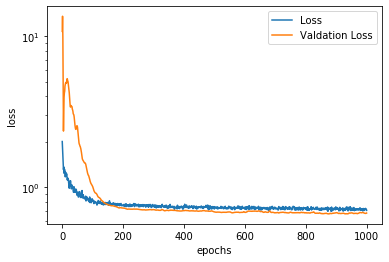

In [14]:
plt.yscale('log')

plt.ylabel("loss")
plt.xlabel("epochs")

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.legend(["Loss", "Valdation Loss"])

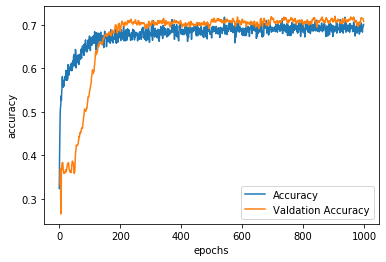

In [15]:
plt.ylabel("accuracy")
plt.xlabel("epochs")

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.legend(["Accuracy", "Valdation Accuracy"])

(<matplotlib.axes._subplots.AxesSubplot at 0x7f64176cbfd0>,
 <matplotlib.collections.PathCollection at 0x7f6470fce0b8>)

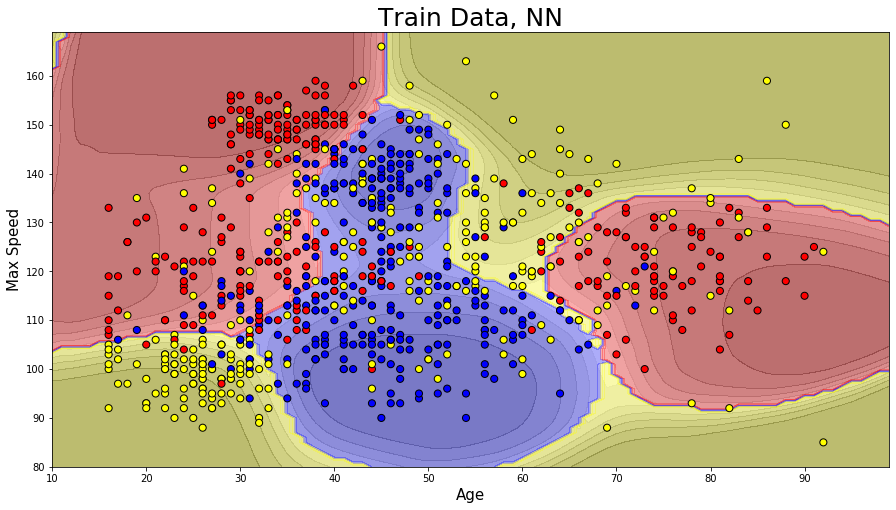

In [16]:
plotPrediction(model, X_train_2_dim[:, 1], X_train_2_dim[:, 0], 
               'Age', 'Max Speed', y_train,
                title="Train Data, NN")

(<matplotlib.axes._subplots.AxesSubplot at 0x7f6417591128>,
 <matplotlib.collections.PathCollection at 0x7f64172ecc50>)

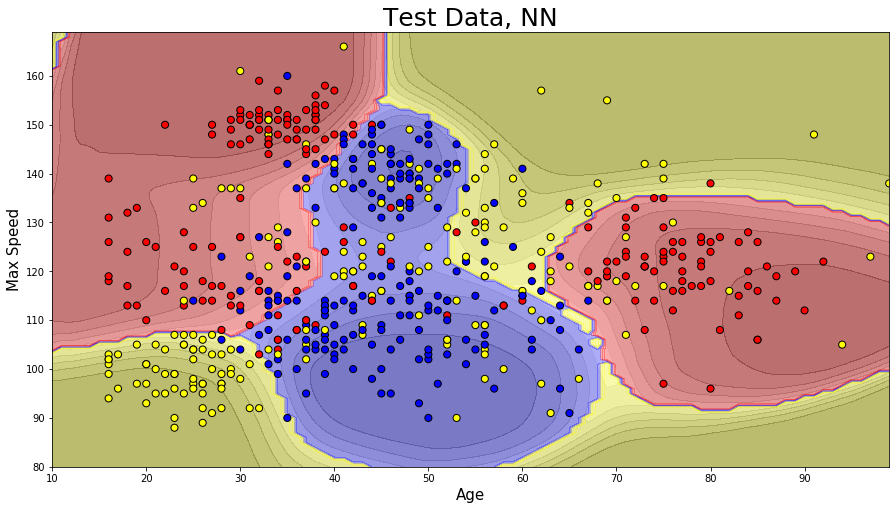

In [17]:
plotPrediction(model, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test,
                title="Test Data, NN")

In [141]:
xx,yy = meshGrid()
xx.shape, yy.shape

((90, 90), (90, 90))

In [149]:
mesh_data = np.c_[yy.ravel(), xx.ravel()]
mesh_data.shape

(8100, 2)

In [150]:
mesh_data[0]

array([80, 10])

In [151]:
pred = model.predict(mesh_data)
pred.shape

(8100, 3)

In [152]:
pred_sparse = pred.argmax(axis=1)
pred_sparse.shape

(8100,)

In [153]:
np.unique(pred_sparse, return_counts=True)

(array([0, 1, 2]), array([3217, 1688, 3195]))

### Direct Training Tree

In [154]:
from sklearn.tree import DecisionTreeClassifier

dt_model = DecisionTreeClassifier()
%time dt_model.fit(X_train_2_dim, y_train)

CPU times: user 3.35 ms, sys: 253 µs, total: 3.6 ms
Wall time: 7.62 ms


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [148]:
dt_model.score(X_train_2_dim, y_train)

0.96

In [25]:
dt_model.score(X_test_2_dim, y_test)

0.595

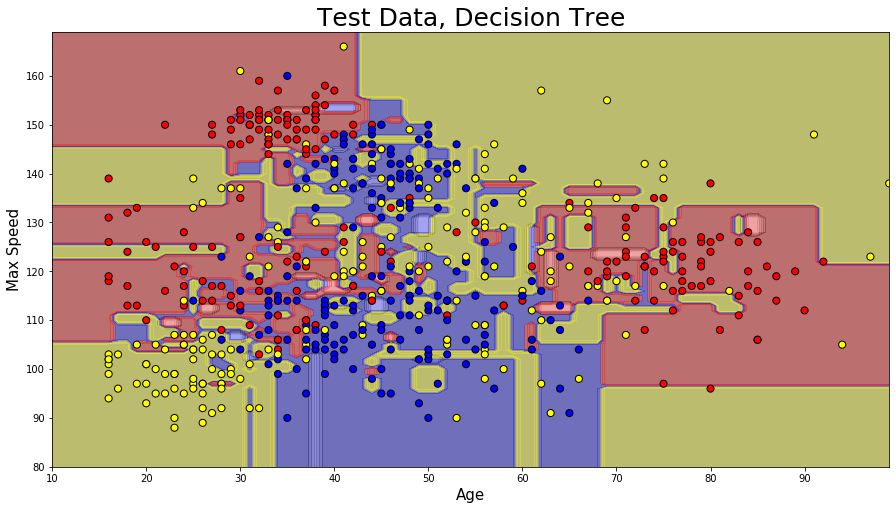

In [26]:
plotPrediction(dt_model, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test,
                title="Test Data, Decision Tree");

### Surrogate Tree

In [27]:
from sklearn.tree import DecisionTreeClassifier

surrogate_model = DecisionTreeClassifier()
%time surrogate_model.fit(mesh_data, pred_sparse)

CPU times: user 10.1 ms, sys: 90 µs, total: 10.2 ms
Wall time: 9.77 ms


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

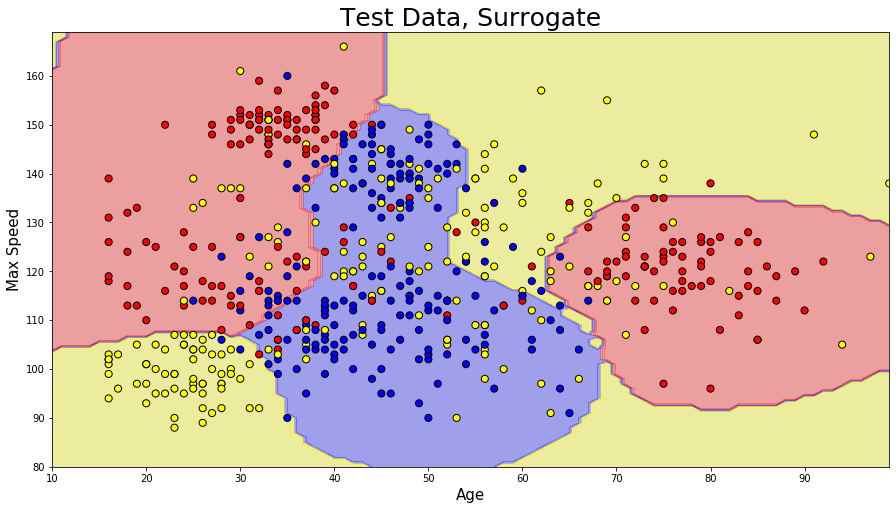

In [28]:
plotPrediction(surrogate_model, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test,
                title="Test Data, Surrogate");

In [29]:
surrogate_model.tree_.max_depth

13

In [30]:
surrogate_model.score(mesh_data, pred_sparse)

1.0

In [31]:
surrogate_model.score(X_train_2_dim, y_train)

0.7111111111111111

In [32]:
surrogate_model.score(X_test_2_dim, y_test)

0.7083333333333334

## Reduce Depth: 7

In [57]:
from sklearn.tree import DecisionTreeClassifier

surrogate_model = DecisionTreeClassifier(max_depth=7)
%time surrogate_model.fit(mesh_data, pred_sparse)

CPU times: user 9.04 ms, sys: 888 µs, total: 9.93 ms
Wall time: 14.2 ms


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [58]:
surrogate_model.tree_.max_depth

7

In [59]:
surrogate_model.score(mesh_data, pred_sparse)

0.9753086419753086

In [60]:
surrogate_model.score(X_train_2_dim, y_train)

0.71

In [61]:
surrogate_model.score(X_test_2_dim, y_test)

0.71

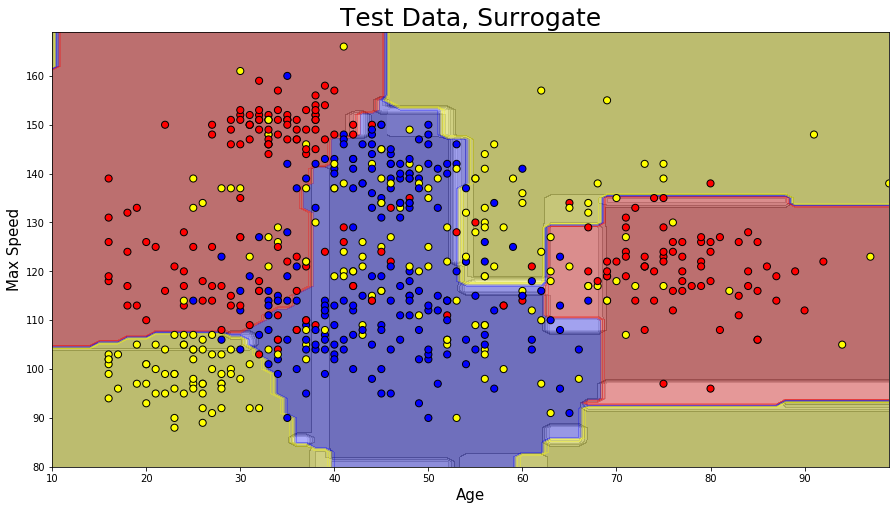

In [62]:
plotPrediction(surrogate_model, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test,
                title="Test Data, Surrogate");

## Reduce Depth: 5

In [63]:
from sklearn.tree import DecisionTreeClassifier

surrogate_model = DecisionTreeClassifier(max_depth=5)
%time surrogate_model.fit(mesh_data, pred_sparse)

CPU times: user 6.44 ms, sys: 0 ns, total: 6.44 ms
Wall time: 7.9 ms


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [64]:
surrogate_model.tree_.max_depth

5

In [65]:
surrogate_model.score(mesh_data, pred_sparse)

0.9388888888888889

In [66]:
surrogate_model.score(X_train_2_dim, y_train)

0.7

In [67]:
surrogate_model.score(X_test_2_dim, y_test)

0.685

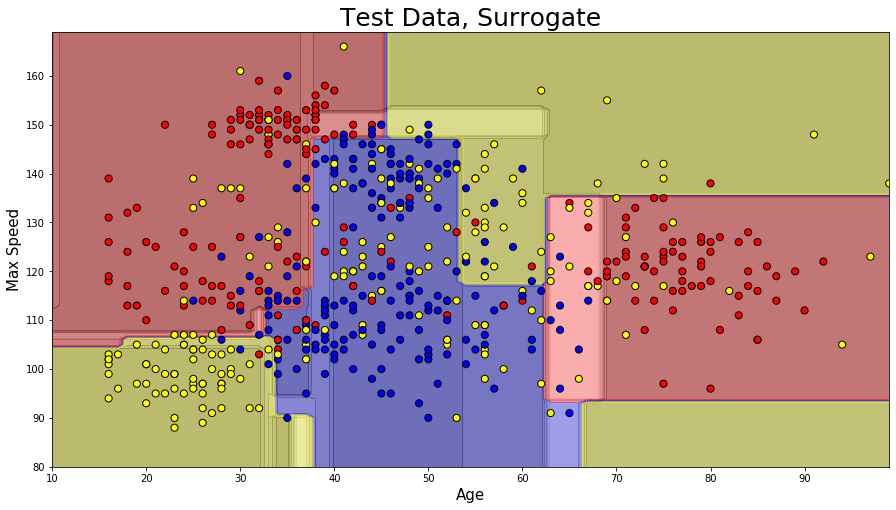

In [68]:
plotPrediction(surrogate_model, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test,
                title="Test Data, Surrogate");

## Reduce Depth: 4

In [240]:
from sklearn.tree import DecisionTreeClassifier

surrogate_model = DecisionTreeClassifier(
    max_depth=4,
    presort=True,
    max_leaf_nodes = 4
    # max_leaf_nodes = 6
                                         )
%time surrogate_model.fit(mesh_data, pred_sparse)

CPU times: user 4.13 ms, sys: 0 ns, total: 4.13 ms
Wall time: 6.62 ms


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
                       max_features=None, max_leaf_nodes=4,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=True,
                       random_state=None, splitter='best')

In [241]:
surrogate_model.tree_.max_depth

2

In [242]:
surrogate_model.score(mesh_data, pred_sparse)

0.6996296296296296

In [243]:
surrogate_model.score(X_train_2_dim, y_train)

0.5955555555555555

In [244]:
surrogate_model.score(X_test_2_dim, y_test)

0.5633333333333334

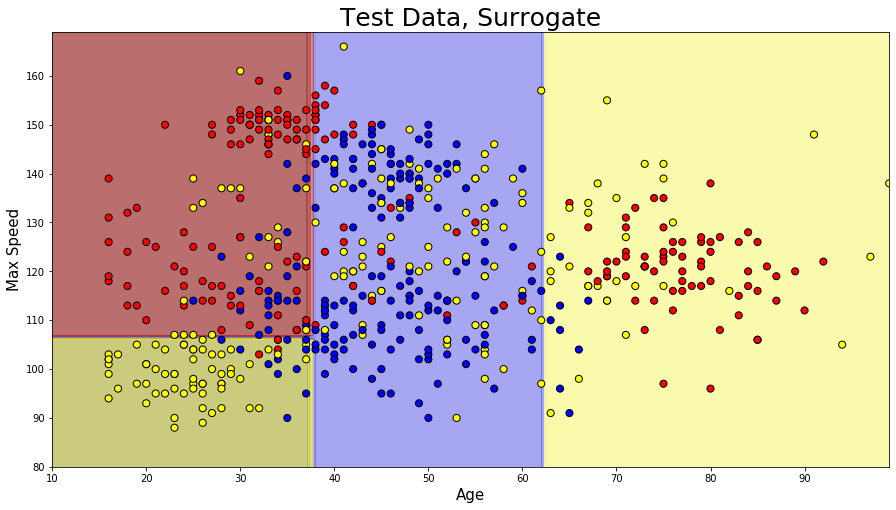

In [245]:
plotPrediction(surrogate_model, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test,
                title="Test Data, Surrogate");

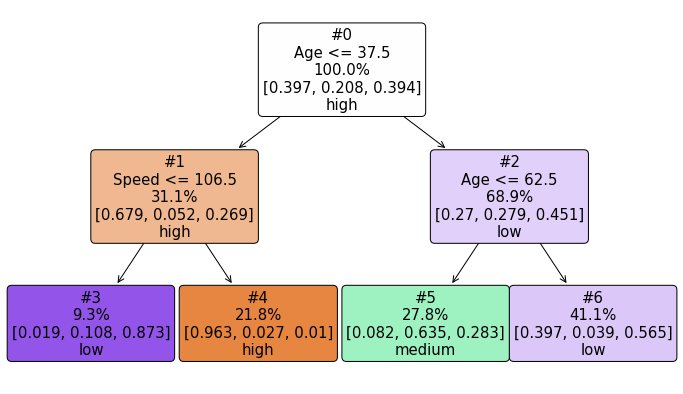

In [249]:
# https://scikit-learn.org/stable/modules/tree.html
# https://scikit-learn.org/stable/auto_examples/tree/plot_iris_dtc.html#sphx-glr-auto-examples-tree-plot-iris-dtc-py
# https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html
# https://stackoverflow.com/questions/42891148/changing-colors-for-decision-tree-plot-created-using-export-graphviz
# https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html#sphx-glr-auto-examples-tree-plot-unveil-tree-structure-py
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 7))
plot_tree(surrogate_model, 
          feature_names=['Speed', 'Age'],
          class_names=['high', 'medium', 'low'],
          impurity=False,
          label='none',
          rounded=True,
          node_ids=True,
          proportion=True,
          filled=True);

In [0]:
# sample = [[100, 36]] # low
sample = [[100, 60]] # medium
# sample = [[120, 17]] # high

In [265]:
surrogate_model.predict(sample)

array([1])

In [266]:
leaf_id = surrogate_model.apply(sample)
leaf_id

array([5])

In [270]:
# https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html
indicator = surrogate_model.decision_path(sample)
indicator.shape

(1, 7)

In [269]:
indicator.toarray()

array([[1, 0, 1, 0, 0, 1, 0]])

## Reduce Depth: 3

In [39]:
from sklearn.tree import DecisionTreeClassifier

# surrogate_model = DecisionTreeClassifier(max_depth=3, min_samples_leaf=250)
surrogate_model = DecisionTreeClassifier(max_depth=3)

%time surrogate_model.fit(mesh_data, pred_sparse)

CPU times: user 5.58 ms, sys: 49 µs, total: 5.63 ms
Wall time: 5.61 ms


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [40]:
surrogate_model.tree_.max_depth

3

In [41]:
surrogate_model.score(mesh_data, pred_sparse)

0.8258024691358025

In [42]:
surrogate_model.score(X_train_2_dim, y_train)

0.6577777777777778

In [43]:
surrogate_model.score(X_test_2_dim, y_test)

0.6433333333333333

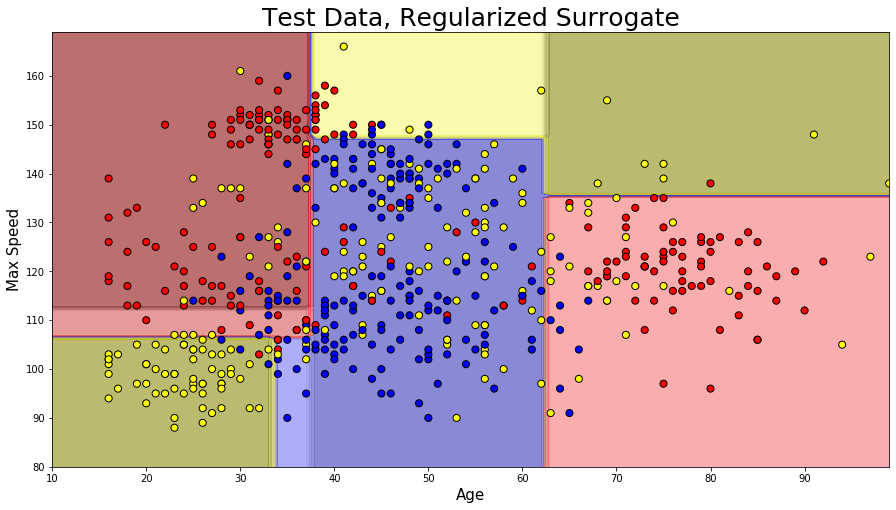

In [44]:
plotPrediction(surrogate_model, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test,
                title="Test Data, Regularized Surrogate");

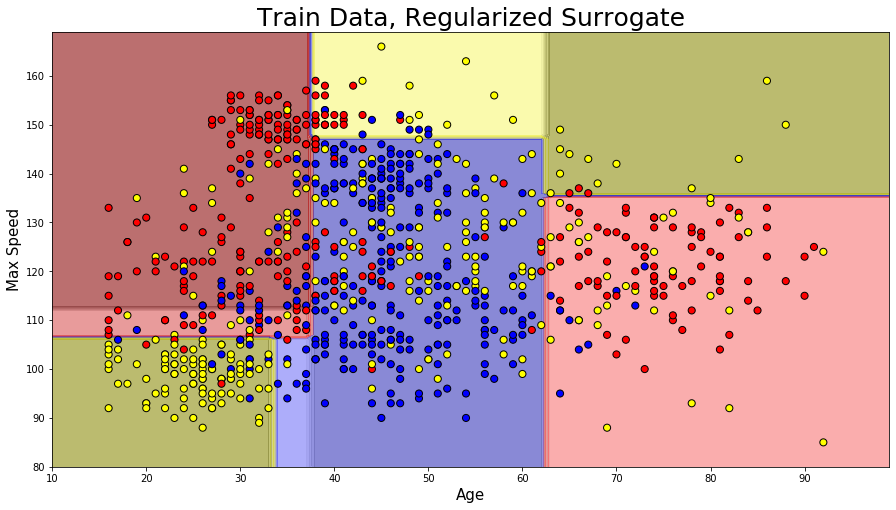

In [45]:
plotPrediction(surrogate_model, X_train_2_dim[:, 1], X_train_2_dim[:, 0], 
               'Age', 'Max Speed', y_train,
                title="Train Data, Regularized Surrogate");

## Reduce Depth: 2

In [46]:
from sklearn.tree import DecisionTreeClassifier

surrogate_model = DecisionTreeClassifier(max_depth=2)

%time surrogate_model.fit(mesh_data, pred_sparse)

CPU times: user 4.02 ms, sys: 1.02 ms, total: 5.04 ms
Wall time: 7.78 ms


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [47]:
surrogate_model.tree_.max_depth

2

In [48]:
surrogate_model.score(mesh_data, pred_sparse)

0.6996296296296296

In [49]:
surrogate_model.score(X_train_2_dim, y_train)

0.5955555555555555

In [53]:
surrogate_model.score(X_test_2_dim, y_test)

0.5633333333333334

In [56]:
surrogate_model.score(X_2_dim, y)

0.5826666666666667

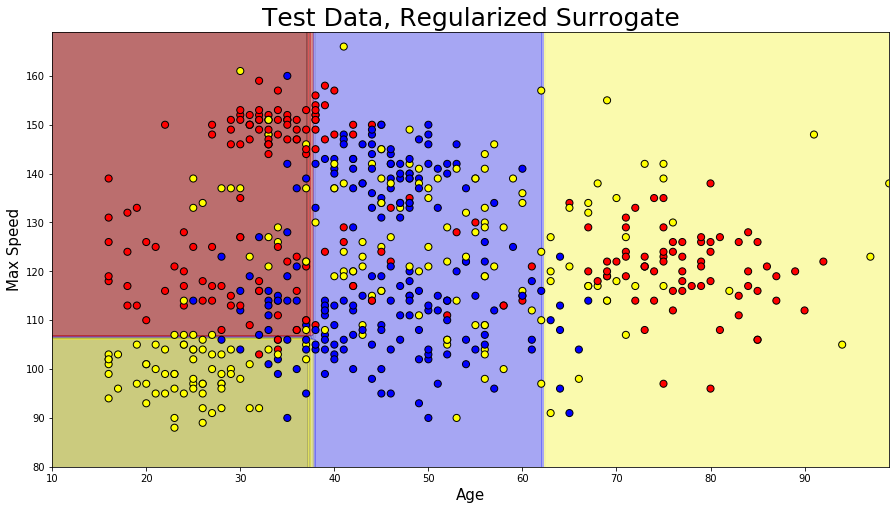

In [51]:
plotPrediction(surrogate_model, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test,
                title="Test Data, Regularized Surrogate");

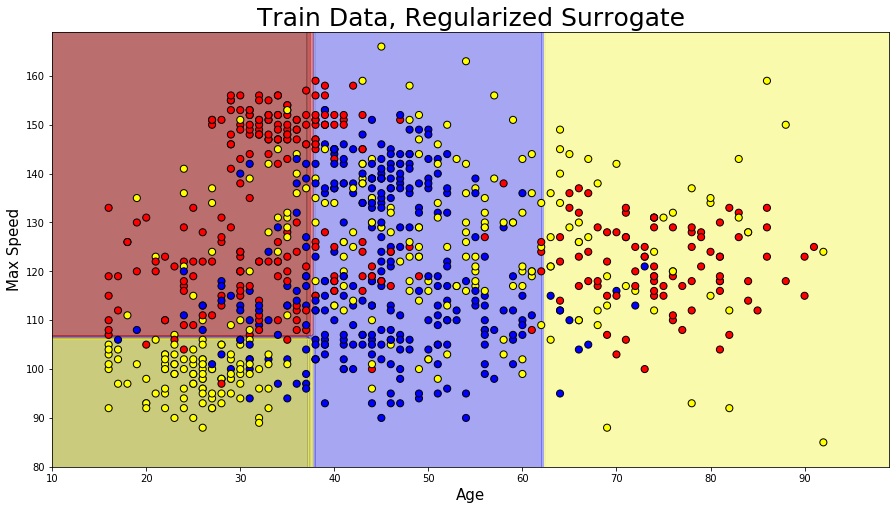

In [52]:
plotPrediction(surrogate_model, X_train_2_dim[:, 1], X_train_2_dim[:, 0], 
               'Age', 'Max Speed', y_train,
                title="Train Data, Regularized Surrogate");

## Reduce Depth: 1

In [88]:
from sklearn.tree import DecisionTreeClassifier

surrogate_model = DecisionTreeClassifier(max_depth=1)

%time surrogate_model.fit(mesh_data, pred_sparse)

CPU times: user 2.97 ms, sys: 1.97 ms, total: 4.93 ms
Wall time: 5.87 ms


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [89]:
surrogate_model.tree_.max_depth

1

In [90]:
surrogate_model.score(mesh_data, pred_sparse)

0.5220987654320988

In [91]:
surrogate_model.score(X_train_2_dim, y_train)

0.35888888888888887

In [92]:
surrogate_model.score(X_test_2_dim, y_test)

0.35

In [93]:
surrogate_model.score(X_2_dim, y)

0.35533333333333333

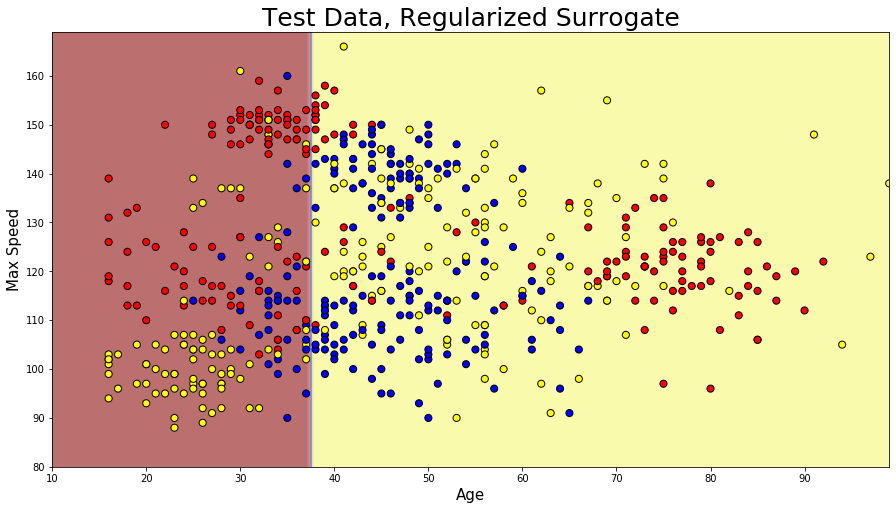

In [94]:
plotPrediction(surrogate_model, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test,
                title="Test Data, Regularized Surrogate");

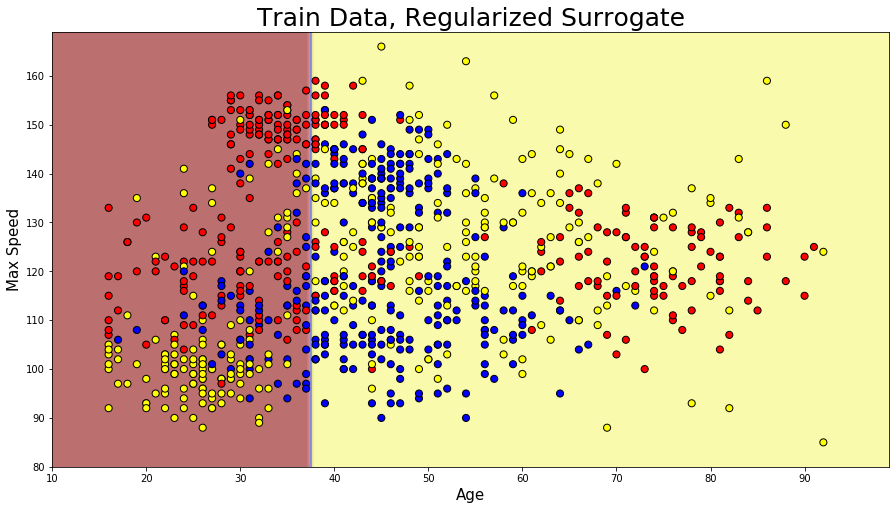

In [95]:
plotPrediction(surrogate_model, X_train_2_dim[:, 1], X_train_2_dim[:, 0], 
               'Age', 'Max Speed', y_train,
                title="Train Data, Regularized Surrogate");

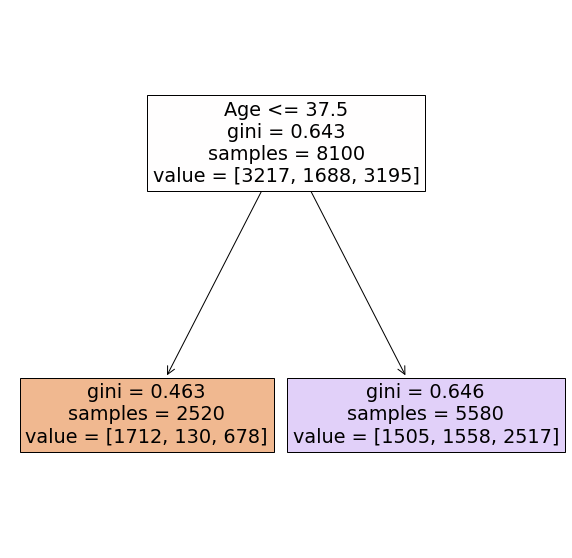

In [100]:
# https://scikit-learn.org/stable/auto_examples/tree/plot_iris_dtc.html#sphx-glr-auto-examples-tree-plot-iris-dtc-py
# https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plot_tree(surrogate_model, 
          feature_names=['Speed', 'Age'],
          filled=True);